[<img src="https://gitlab.irit.fr/toc/etu-n7/controle-optimal/-/raw/master/ressources/Logo-toulouse-inp-N7.png" alt="N7" height="80"/>](https://gitlab.irit.fr/toc/etu-n7/controle-optimal)
<img src="https://gitlab.irit.fr/toc/ens-n7/texCoursN7/-/raw/main/logo-insa.png" alt="INSA" height="80" style="margin-left:50px"/>

# Méthodes de Runge-Kutta

- Date : 2024-2025
- Durée approximative : 1h15

<div style="width:95%;
            margin:10px;
            padding:8px;
            background-color:#afa;
            border:2px solid #bbffbb;
            border-radius:10px;
            font-weight:bold;
            font-size:1.5em;
            text-align:center;">
Introduction
</div>

**Méthode à un pas explicite.** On désire calculer une approximation de la solution, notée $x(\cdot, t_0, x_0)$, sur l'intervalle 
$I := [t_0, t_f]$ du problème de Cauchy
\begin{equation*}
    \dot{x}(t) = f(t, x(t)), \quad x(t_0) = x_0,
\end{equation*}
où $f \colon \mathbb{R} \times \mathbb{R}^n \to \mathbb{R}^n$ est une application suffisamment régulière. 
On considère pour cela une subdivision de l'intervalle $I$ : 
$$
    t_0 < t_1 < \cdots < t_N := t_f
$$

On note $h_i := t_{i+1} - t_i$ pour $i \in \llbracket 0, N-1 \rrbracket$, les **pas** de la subdivision et 
$h_{\max} := \max_i(h_i)$ le pas le plus long. L'idée est de calculer une approximation de 
la solution en les points de discrétisation. On souhaite donc approcher $x(t_i, t_0, x_0)$ pour 
$i \in \llbracket 1, N \rrbracket$. 

On appelle *méthode à un pas explicite*, toute méthode calculant un N-uplet $(x_1, \ldots, x_N) \in {(\mathbb{R}^n)}^N$ tel que la valeur $x_{i+1}$ est calculée en fonction de $t_i$, $h_i$ et $x_i$ de la forme :

$$
    x_{i+1} = x_i + h_i\, \Phi(t_i, x_i, h_i).
$$

Pour approcher la solution, nous utiliserons une méthode à un pas. Si on note $x_h^* := (x_1^*, \ldots, x_N^*)$ une solution au problème discrétisé (obtenue par la méthode à un pas considérée), alors on souhaite que 
$$
    x_i^* \approx x(t_i, t_0, x_0) \quad \text{pour tout } i \in \llbracket 1, N \rrbracket.
$$

**Ordre de convergence.** On considère à partir de maintenant un pas de temps $h$ **uniforme**. Une méthode à un pas explicite est **convergente** si pour toute solution $x(\cdot, t_0, x_0)$, la suite ${(x_i)}_i$ définie par $x_{i+1} = x_i + h\, \Phi(t_i, x_i, h)$ vérifie 
$$
    \max_{1 \le i \le N}\, \|{x(t_i, t_0, x_0) - x_i}\| \to 0 
    \quad\text{quand}\quad h \to 0.
$$

Si la convergence est d'ordre $p$ alors il existe une constante $C \ge 0$ telle que

$$
    E := \max_{1 \le i \le N}\, \|{x(t_i, t_0, x_0) - x_i}\| \le C\, h^p.
$$

Faisons l'hypothèse que $E = M\, h^p$ pour un certain $M \ge 0$. En passant au logarithme, on obtient

$$
    \log(E) = \log(M) + p\, \log(h).
$$

Nous en déduisons que si on trace $\log(E)$ en fonction de $\log(h)$, on doit obtenir une droite de pente $p$. C'est ce que nous allons vérifier dans ce TP.

**Objectif.** Nous allons dans ce TP, implémenter quelques méthodes (à un pas) de [Runge-Kutta](https://fr.wikipedia.org/wiki/Méthodes_de_Runge-Kutta) explicites et 
étudier leur convergence. On appelle *méthode de Runge-Kutta explicite à $s$ étages*, la méthode définie par le schéma

$$
    \begin{aligned}
        k_1 &= f(t_0, x_0) \\
        k_2 &= f(t_0 + c_2 h, x_0 + h a_{21} k_1) \\
        \vdots & \\[-1em]
        k_s &= f(t_0 + c_s h, x_0 + h \sum_{j=1}^{s-1} a_{sj} k_j) \\
        x_1 &= x_0 + h \sum_{i=1}^{s} b_i k_i,
    \end{aligned}
$$
où les coefficients $c_i$, $a_{ij}$ et $b_i$ sont des constantes qui définissent précisément le schéma. 
On supposera toujours dans la suite que $c_1 = 0$ et $c_i = \sum_{j=1}^{i-1} a_{ij}$, pour $i = 2, \ldots, s$.

In [39]:
# activate local project
using Pkg
Pkg.activate(".")

# load packages
using Plots
using Plots.PlotMeasures
using Polynomials

#
px = PlotMeasures.px;

  Activating project at `~/Boulot/cours/calcul_differentiel_edo/enseignants/modia/tp`


In [46]:
# Fonctons auxiliaires 

function method_infos(method)

    if method == :euler 
        method_func = euler
        method_name = "Euler"
        methode_stages = 1
    elseif method == :runge 
        method_func = runge
        method_name = "Runge"
        methode_stages = 2
    elseif method == :heun
        method_func = heun
        method_name = "Heun"
        methode_stages = 3
    elseif method == :rk4
        method_func = rk4
        method_name = "RK4"
        methode_stages = 4
    else 
        error("Méthode d'intégration non reconnue")
    end

    return method_func, method_name, methode_stages

end

function convergence(method, f, x0, tspan, sol,  Nspan)

    # Récupération des informations sur la méthode
    method_func, method_name, methode_stages = method_infos(method)
    
    # Ecriture des choix de paramètres
    println("Méthode d'intégration : ", method_name)

    plts  = [] # Liste des graphiques

    for N ∈ Nspan

        # Solution approchée
        ts, xs = method_func(f, x0, tspan, N) # Appel de la méthode d'intégraton

        # Affichage de la solution approchée
        plt = plot(ts, xs, label=method_name, marker=:circle)

        # Affichage de la solution analytique
        plot!(plt, sol, label="Analytic")

        # Mise en forme du graphique
        plot!(plt, xlims=(tspan[1]-0.1, tspan[2]+0.1), ylims=(-0.2, 1.65), 
        title="h=$(round((tspan[2]-tspan[1])/N, digits=2))", titlefont = font(12,"Calibri"),
        xlabel="t", ylabel="x(t)", left_margin=15px, bottom_margin=15px, top_margin=10px, right_margin=15px)

        # Ajout du graphique à la liste des graphiques
        push!(plts, plt)

    end

    return plts

end

xlims_ = (1e-4, 1e0)
ylims_ = (1e-13, 1e1)
xlims_nfe_ = (1e1, 1e4)
ylims_nfe_ = (1e-13, 1e1)

function ordre(method, f, x0, tspan, sol, hspan, nfespan; 
    xlims=xlims_, ylims=ylims_, xlims_nfe=xlims_nfe_, ylims_nfe=ylims_nfe_)

    plts = [] # Liste des graphiques

    #
    plt1 = plot(xaxis=:log, yaxis=:log); push!(plts, plt1)
    plt2 = plot(xaxis=:log, yaxis=:log); push!(plts, plt2)

    #
    plts = ordre(plts, method, f, x0, tspan, sol, hspan, nfespan, 
        xlims=xlims, ylims=ylims, xlims_nfe=xlims_nfe, ylims_nfe=ylims_nfe)

    # Mise en forme des graphiques
    plot!(plts[1], titlefont = font(12, "Calibri"), legend=:topleft,
    xlabel="h", ylabel="Error", left_margin=15px, bottom_margin=15px, top_margin=10px, right_margin=15px)

    plot!(plts[2], titlefont = font(12, "Calibri"), legend=:topright,
    xlabel="Calls to f", ylabel="Error", left_margin=15px, bottom_margin=15px, top_margin=10px, right_margin=15px)

    return plts
    
end

function ordre(plts_in, method, f, x0, tspan, sol, hspan, nfespan; 
    xlims=xlims_, ylims=ylims_, xlims_nfe=xlims_nfe_, ylims_nfe=ylims_nfe_)

    # Copie du graphique d'entrée
    plts = deepcopy(plts_in)

    # Récupération des informations sur la méthode
    method_func, method_name, methode_stages = method_infos(method)
    
    # Ecriture des choix de paramètres
    println("Méthode d'intégration : ", method_name)

    # Les différents nombre de pas de temps
    Nspan = round.(Int, (tspan[2]-tspan[1]) ./ hspan)

    # Calcul de l'erreur
    err = []

    for N ∈ Nspan

        # Solution approchée
        ts, xs = method_func(f, x0, tspan, N)

        # On calcule l'erreur en norme infinie
        push!(err, maximum(abs.(xs .- sol.(ts))))
        
    end

    # calcul par régression linéaire de la pente de la droite et de l'ordonnée à l'origine
    reg = fit(log10.(hspan), log10.(err), 1)
    K   = 10^reg[0]
    p   = reg[1]
    println("\nconstante du grand O : K = $(round(K, digits=5))")
    println("ordre de convergence : p = $(round(p, digits=5))")

    # Affichage de l'erreur en fonction du pas de temps: on enlève la constante K
    plot!(plts[1], hspan, err, xaxis=:log, yaxis=:log, label="$method_name", marker=:circle)

    # Affichage de la droite de régression
    #plot!(plt, hspan, hspan .^ p, label="$method_name Regression", linestyle=:dash)
    
    # Mise en forme du graphique
    plot!(plts[1], xlims=xlims, ylims=ylims)

    # Calcul de l'erreur en fonction du nombre d'appels à la fonction f
    err = []

    for Nfe ∈ Nfespan

        #
        N = round(Int, Nfe / methode_stages)

        # Solution approchée
        ts, xs = method_func(f, x0, tspan, N)

        # On calcule l'erreur en norme infinie
        push!(err, maximum(abs.(xs .- sol.(ts))))
        
    end

    # Affchage de l'erreur en fonction du nombre d'appels à la fonction f
    # Nfespan = methode_stages .* Nspan
    plot!(plts[2], Nfespan, err, xaxis=:log, yaxis=:log, label="$method_name", marker=:circle)

    # Mise en forme du graphique
    plot!(plts[2], xlims=xlims_nfe, ylims=ylims_nfe)

    return plts
    
end;

hspan_   = 10 .^ range(-4, stop=0, length=20)
Nfespan_ = 10 .^ range( 0, stop=4, length=20);

<div style="width:95%;
            margin:10px;
            padding:8px;
            background-color:#afa;
            border:2px solid #bbffbb;
            border-radius:10px;
            font-weight:bold;
            font-size:1.5em;
            text-align:center;">
L'exemple d'étude
</div>

On s'intéresse dans ce TP au problème de Cauchy

$$
    \dot{x}(t) = (1-2t) x(t), \quad x(0) = x_0 = 1
$$

sur l'intervalle $[0, 3]$.

In [47]:
# Définition du problème de Cauchy
f(t, x) = (1-2t)x    # Second membre f(t, x)
x0 = 1.0             # Condition initiale
tspan = (0.0, 3.0);  # Intervalle de temps

### Exercice 1

* Calculer la solution analytique de l'exemple ci-dessus et la coder dans la fonction `sol` ci-dessous.

In [48]:
# Solution analytique
function sol(t)
    return exp(t-t^2)
end;

<div style="width:95%;
            margin:10px;
            padding:8px;
            background-color:#afa;
            border:2px solid #bbffbb;
            border-radius:10px;
            font-weight:bold;
            font-size:1.5em;
            text-align:center;">
La méthode d'Euler
</div>

On rappelle que la méthode d'Euler est donnée par :

$$
\left\{
\begin{array}{l}
x_{n+1} = x_n + h f(t_n, x_n) \\
x_0 = x(t_0)
\end{array}
\right.
$$

### Exercice 2

1. Implémenter la méthode d'Euler dans la fonction `euler` ci-dessous.
2. Vérifier la convergence de la méthode d'Euler sur l'exemple donné dans la cellule d'après.

In [49]:
# Implémentation de la méthode d'Euler
function euler(f, x0, tspan, N)
    t0, tf = tspan
    h = (tf - t0) / N
    t = t0
    x = x0
    ts = [t0]
    xs = [x0]
    for i in 1:N
        x = x + h * f(t, x)
        t = t + h
        push!(ts, t)
        push!(xs, x)
    end
    return ts, xs
end;

Méthode d'intégration : Euler


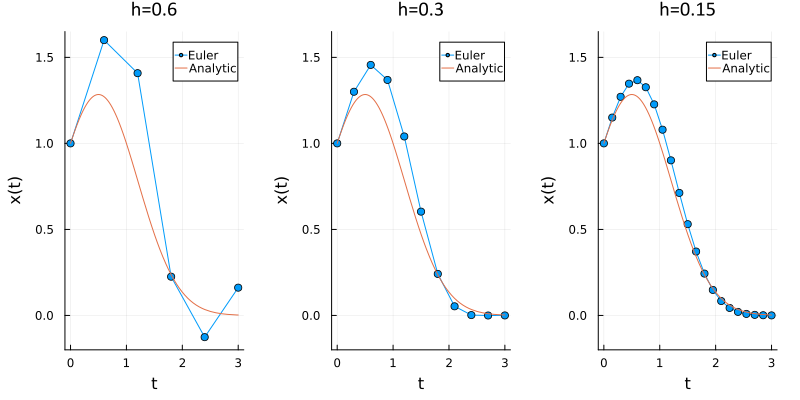

In [52]:
# Convergence de la méthode sur l'exemple
method = :euler
Nspan  = [5, 10, 20]

# Calcul des graphiques
plts = convergence(method, f, x0, tspan, sol, Nspan)

# Affichage des graphiques
plot(plts..., layout=(1, length(Nspan)), size=(800, 400))

3. Afficher l'erreur globale de la méthode d'Euler en fonction de $h$ et vérifier que l'erreur est bien en $O(h)$.

Méthode d'intégration : Euler



constante du grand O : K = 0.93153
ordre de convergence : p = 1.01404


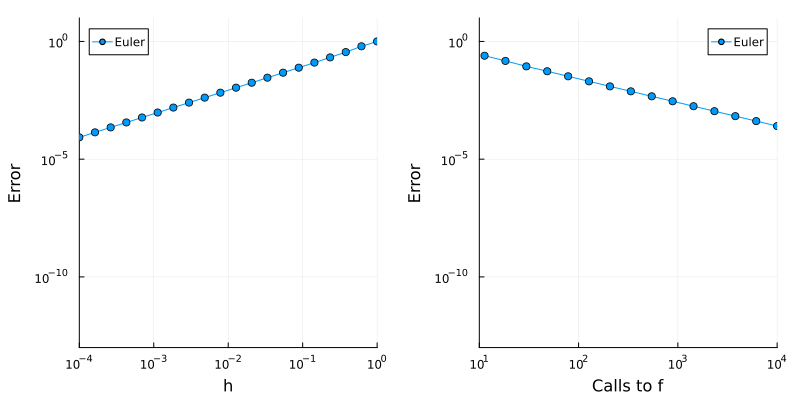

In [65]:
# Ordre de convergence de la méthode
method  = :euler
hspan   = hspan_[1e-7 .≤ hspan_ .≤ 1]
Nfespan = Nfespan_[10 .≤ Nfespan_ .≤ 1e7]

# Calcul du graphique
plt_order_euler = ordre(method, f, x0, tspan, sol, hspan, Nfespan)

# Affichage du graphique
plot(plt_order_euler..., layout=(1, 2), size=(800, 400))

<div style="width:95%;
            margin:10px;
            padding:8px;
            background-color:#afa;
            border:2px solid #bbffbb;
            border-radius:10px;
            font-weight:bold;
            font-size:1.5em;
            text-align:center;">
La méthode de Runge 
</div>

On rappelle que la méthode de Runge est donnée par :

$$
\left\{
\begin{array}{l}
\displaystyle x_{n+1} = x_n + h\, f\left(t_{n} + \frac{h}{2}, ~x_n + \frac{h}{2} f(t_n, x_n)\right) \\
x_0 = x(t_0)
\end{array}
\right.
$$

### Exercice 3

1. Implémenter la méthode de Runge dans la fonction `runge` ci-dessous.
2. Vérifier la convergence de la méthode de Runge sur l'exemple donné dans la cellule d'après.
3. Calculer l'erreur globale de la méthode de Runge en fonction de $h$ et vérifier que l'erreur est bien en $O(h^2)$.

In [66]:
function runge(f, x0, tspan, N)
    t0, tf = tspan
    h = (tf - t0) / N
    t = t0
    x = x0
    ts = [t0]
    xs = [x0]
    for i in 1:N
        k1 = f(t, x)
        k2 = f(t + h/2, x + h/2 * k1)
        x = x + h * k2
        t = t + h
        push!(ts, t)
        push!(xs, x)
    end
    return ts, xs
end;

Méthode d'intégration : Runge


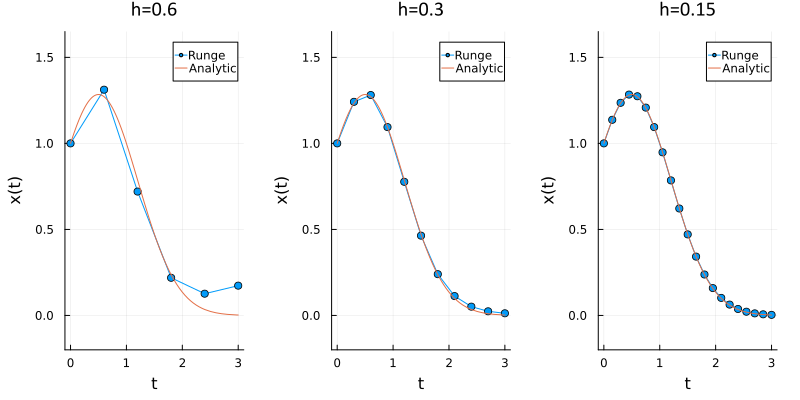

In [67]:
# Convergence de la méthode sur l'exemple
method = :runge
Nspan  = [5, 10, 20]

# Calcul des graphiques
plts = convergence(method, f, x0, tspan, sol, Nspan)

# Affichage des graphiques
plot(plts..., layout=(1, length(Nspan)), size=(800, 400))

Méthode d'intégration : Runge

constante du grand O : K = 0.17697
ordre de convergence : p = 2.04327


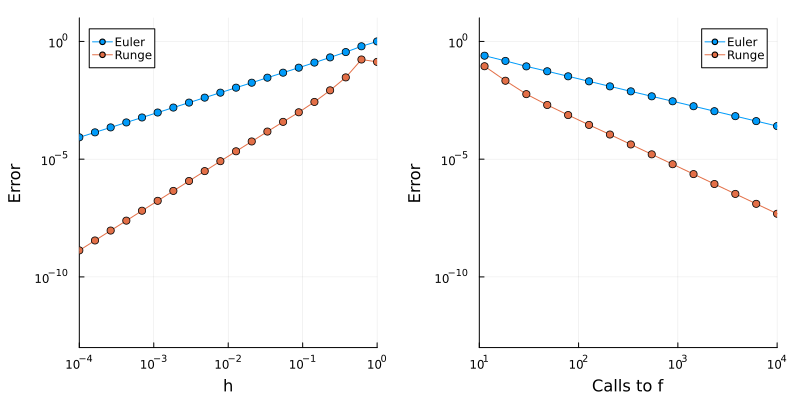

In [68]:
# Ordre de convergence de la méthode
method  = :runge
hspan   = hspan_[1e-5 .≤ hspan_ .≤ 1]
Nfespan = Nfespan_[10 .≤ Nfespan_ .≤ 1e6]

# Calcul du graphique
plt_order_runge = ordre(plt_order_euler, method, f, x0, tspan, sol, hspan, Nfespan)

# Affichage du graphique
plot(plt_order_runge..., layout=(1, 2), size=(800, 400))

<div style="width:95%;
            margin:10px;
            padding:8px;
            background-color:#afa;
            border:2px solid #bbffbb;
            border-radius:10px;
            font-weight:bold;
            font-size:1.5em;
            text-align:center;">
La méthode de Heun 
</div>

On rappelle que la méthode de Heun est donnée par :

$$
\left\{
\begin{array}{l}
    \displaystyle k_1 = f(t_n, x_n) \\[1em]
    \displaystyle k_2 = f(t_n + \frac{h}{3}, x_n + \frac{h}{3} k_1) \\[1em]
    \displaystyle k_3 = f(t_n + \frac{2}{3}h, x_n + \frac{2}{3}h\, k_2) \\[1em]
    \displaystyle x_{n+1} = x_n + h\left(\frac{1}{4} k_1 + \frac{3}{4} k_3\right), \quad 
    \displaystyle x_0 = x(t_0)
\end{array}
\right.
$$

### Exercice 4

1. Implémenter la méthode de Heun dans la fonction `heun` ci-dessous.
2. Vérifier la convergence de la méthode de Heun sur l'exemple donné dans la cellule d'après.
3. Calculer l'erreur globale de la méthode de Heun en fonction de $h$ et vérifier que l'erreur est bien en $O(h^3)$.

In [69]:
function heun(f, x0, tspan, N)
    t0, tf = tspan
    h = (tf - t0) / N
    t = t0
    x = x0
    ts = [t0]
    xs = [x0]
    for i in 1:N
        k1 = f(t, x)
        k2 = f(t + h/3, x + h/3 * k1)
        k3 = f(t + 2h/3, x + 2h/3 * k2)
        x = x + h/4 * (k1 + 3k3)
        t = t + h
        push!(ts, t)
        push!(xs, x)
    end
    return ts, xs
end;

Méthode d'intégration : Heun


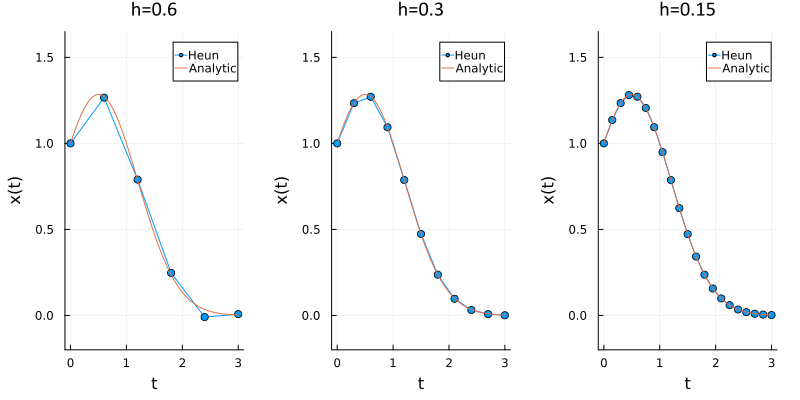

In [70]:
# Convergence de la méthode sur l'exemple
method = :heun
Nspan  = [5, 10, 20]

# Calcul des graphiques
plts = convergence(method, f, x0, tspan, sol, Nspan)

# Affichage des graphiques
plot(plts..., layout=(1, length(Nspan)), size=(800, 400))

Méthode d'intégration : Heun

constante du grand O : K = 0.15948
ordre de convergence : p = 3.132


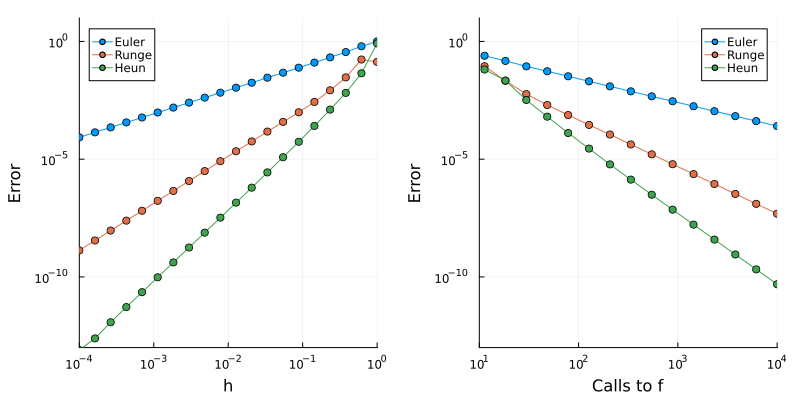

In [71]:
# Ordre de convergence de la méthode
method = :heun
hspan   = hspan_[1e-4 .≤ hspan_ .≤ 1]
Nfespan = Nfespan_[10 .≤ Nfespan_ .≤ 1e5]

# Calcul du graphique
plt_order_heun = ordre(plt_order_runge, method, f, x0, tspan, sol, hspan, Nfespan)

# Affichage du graphique
plot(plt_order_heun..., layout=(1, 2), size=(800, 400))

<div style="width:95%;
            margin:10px;
            padding:8px;
            background-color:#afa;
            border:2px solid #bbffbb;
            border-radius:10px;
            font-weight:bold;
            font-size:1.5em;
            text-align:center;">
La méthode de Runge-Kutta d'ordre 4
</div>

On rappelle que la méthode de Runge-Kutta d'ordre 4 est donnée par :

$$
\left\{
\begin{array}{l}
    \displaystyle k_1 = f(t_n, x_n) \\[1em]
    \displaystyle k_2 = f(t_n + \frac{h}{2}, x_n + \frac{h}{2} k_1) \\[1em]
    \displaystyle k_3 = f(t_n + \frac{h}{2}, x_n + \frac{h}{2} k_2) \\[1em]
    \displaystyle k_4 = f(t_n + h, x_n + h\, k_3) \\[1em]
    \displaystyle x_{n+1} = x_n + \frac{h}{6} (k_1 + 2 k_2 + 2 k_3 + k_4), \quad 
    \displaystyle x_0 = x(t_0)
\end{array}
\right.
$$

### Exercice 5

1. Implémenter la méthode de Runge-Kutta d'ordre 4 dans la fonction `rk4` ci-dessous.
2. Vérifier la convergence de la méthode de Runge-Kutta d'ordre 4 sur l'exemple donné dans la cellule d'après.
3. Calculer l'erreur globale de la méthode de Runge-Kutta d'ordre 4 en fonction de $h$ et vérifier que l'erreur est bien en $O(h^4)$.

In [72]:
function rk4(f, x0, tspan, N)
    t0, tf = tspan
    h = (tf - t0) / N
    t = t0
    x = x0
    ts = [t0]
    xs = [x0]
    for i in 1:N
        k1 = f(t, x)
        k2 = f(t + h/2, x + h/2 * k1)
        k3 = f(t + h/2, x + h/2 * k2)
        k4 = f(t + h, x + h * k3)
        x = x + h/6 * (k1 + 2k2 + 2k3 + k4)
        t = t + h
        push!(ts, t)
        push!(xs, x)
    end
    return ts, xs
end;

Méthode d'intégration : RK4

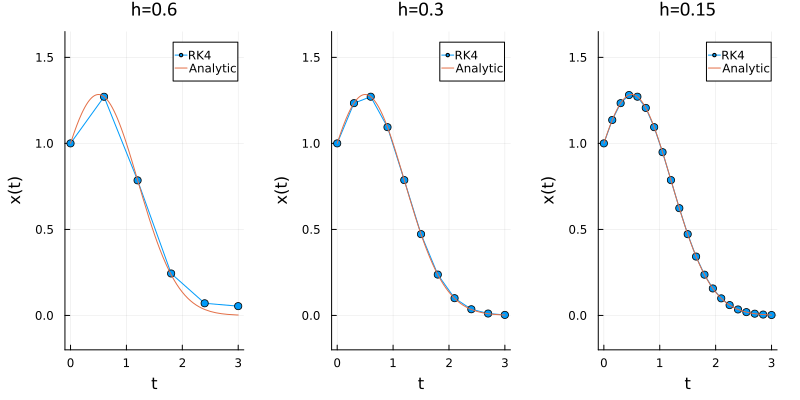

In [73]:
# Convergence de la méthode sur l'exemple
method = :rk4
Nspan  = [5, 10, 20]

# Calcul des graphiques
plts = convergence(method, f, x0, tspan, sol, Nspan)

# Affichage des graphiques
plot(plts..., layout=(1, length(Nspan)), size=(800, 400))

Méthode d'intégration : RK4

constante du grand O : K = 0.24646
ordre de convergence : p = 4.22756


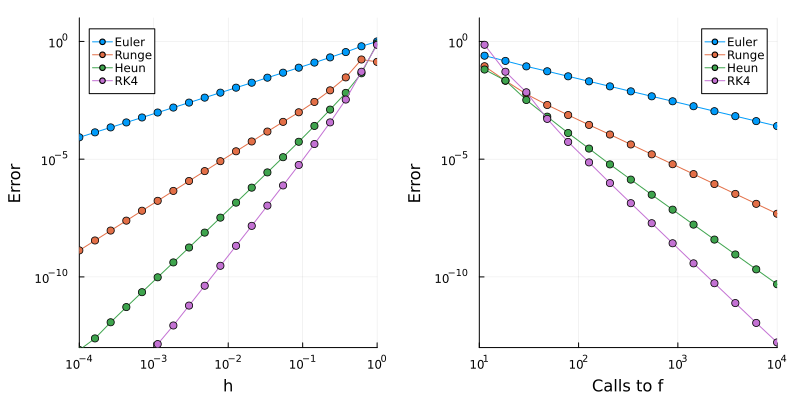

In [74]:
# Ordre de convergence de la méthode
method = :rk4
hspan   = hspan_[1e-3 .≤ hspan_ .≤ 1]
Nfespan = Nfespan_[10 .≤ Nfespan_ .≤ 1e4]

# Calcul du graphique
plt_order_rk4 = ordre(plt_order_heun, method, f, x0, tspan, sol, hspan, Nfespan)

# Affichage du graphique
plot(plt_order_rk4..., layout=(1, 2), size=(800, 400))